In [1]:
import os
import yaml
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import keras
# from keras import layers
import tensorflow as tf
from tensorflow import data as tf_data
from tensorflow.keras import layers, models
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from scipy.optimize import minimize
from pprint import pprint
from tqdm import tqdm

print("Number of available GPUs: ", len(tf.config.list_physical_devices('GPU')))

# read configuration file
with open('config.yml', 'r') as f:
    config = yaml.load(f, Loader=yaml.SafeLoader)

2025-10-09 14:42:50.084030: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-09 14:42:50.136680: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-09 14:42:57.107177: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Number of available GPUs:  2


I0000 00:00:1760038979.445396 3429498 gpu_device.cc:2411] Ignoring visible gpu device (device: 2, name: NVIDIA T400 4GB, pci bus id: 0000:e3:00.0, compute capability: 7.5) with core count: 6. The minimum required count is 8. You can adjust this requirement with the env var TF_MIN_GPU_MULTIPROCESSOR_COUNT.


In [28]:
def get_image_data(f):
    """
    Returns a tuple (Lens ID, image)
    """
    fits_data = fits.getdata(f, ext=0)
    return os.path.basename(f).split('.')[0][:-2], fits_data


def process_image(image):
    # normalize the image to the range [0, 1]
    image = (image - np.min(image)) / (np.max(image) - np.min(image))

    # apply gamma correction
    gamma = find_gamma(image, desired_median=0.2)
    return np.power(image, gamma)


def objective_function(gamma, image, desired_median):
    gamma_corrected_image = np.power(image, gamma)
    median_value = np.median(gamma_corrected_image)
    return (median_value - desired_median)**2


def find_gamma(image, desired_median=0.2, initial_gamma=0.7):
    result = minimize(objective_function, initial_gamma, args=(image, desired_median), method='Nelder-Mead')
    return result.x[0]

Load the saved model

In [3]:
models = sorted(glob(os.path.join(config['data_dir'], 'models', '*.keras')))
pprint(models)

['/nfsdata1/bwedig/lsst-strong-lens-data-challenge/models/bryce_v1_ap99966643.keras']


In [4]:
model = keras.models.load_model(models[0])

I0000 00:00:1760038979.808015 3429498 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46551 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:31:00.0, compute capability: 8.9
I0000 00:00:1760038979.809205 3429498 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46551 MB memory:  -> device: 1, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:b1:00.0, compute capability: 8.9


Take a quick look as the format that the submission CSV needs to have

In [5]:
example_csv = '/grad/bwedig/lsst-strong-lens-data-challenge/submission_format.csv'
example_df = pd.read_csv(example_csv)
print(example_df.head())

            id  preds   ra  dec  zlens  mag_lens_g  mag_lens_r  mag_lens_i  \
0  7.53391E+16      1 -999 -999   -999        -999        -999        -999   
1  7.46439E+16      0 -999 -999   -999        -999        -999        -999   
2  4.42233E+16      1 -999 -999   -999        -999        -999        -999   
3  6.95818E+16      0 -999 -999   -999        -999        -999        -999   
4  6.95997E+16      1 -999 -999   -999        -999        -999        -999   

   mag_lens_z  mag_lens_y  ...  n_l_sers  vel_disp   RA  Dec  mag_object_g  \
0        -999        -999  ...      -999      -999 -999 -999          -999   
1        -999        -999  ...      -999      -999 -999 -999          -999   
2        -999        -999  ...      -999      -999 -999 -999          -999   
3        -999        -999  ...      -999      -999 -999 -999          -999   
4        -999        -999  ...      -999      -999 -999 -999          -999   

   mag_object_r  mag_object_i  mag_object_z  mag_object_y  z_c

Create an empty version of this

In [6]:
df = example_df.iloc[0:0].copy()
print(df)

Empty DataFrame
Columns: [id, preds, ra, dec, zlens, mag_lens_g, mag_lens_r, mag_lens_i, mag_lens_z, mag_lens_y, ell_l, ell_l_PA, Rein, vel disp, sh, sh_PA, srcx, srcy, mag_src_g, mag_src_r, mag_src_i, mag_src_z, mag_src_y, zsrc, ell_s, ell_s_PA, Reff_s, n_s_sers, ell_m, ell_m_PA, Reff_l, n_l_sers, vel_disp, RA, Dec, mag_object_g, mag_object_r, mag_object_i, mag_object_z, mag_object_y, z_central]
Index: []

[0 rows x 41 columns]


Load the `.fits` files, making sure to stack them correctly

In [12]:
data_dir = '/data/bwedig/lsst-strong-lens-data-challenge/test_dataset/test_dataset'

fits_files = sorted(glob(os.path.join(data_dir, '*.fits')))
print(f"Found {len(fits_files)} FITS files.")

unique_ids = set([os.path.basename(f).split('.')[0][:-2] for f in fits_files])
print(f"Found {len(unique_ids)} unique IDs.")

Found 500000 FITS files.
Found 100000 unique IDs.


  0%|          | 0/100000 [00:00<?, ?it/s]

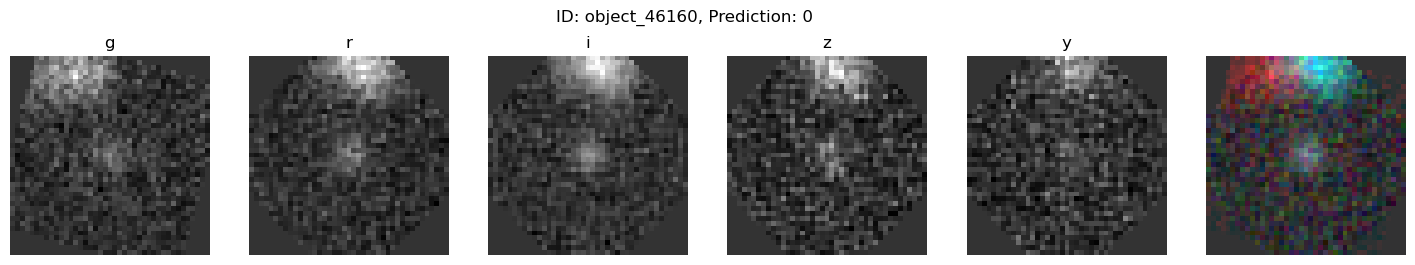

  0%|          | 1/100000 [00:00<8:43:21,  3.18it/s]

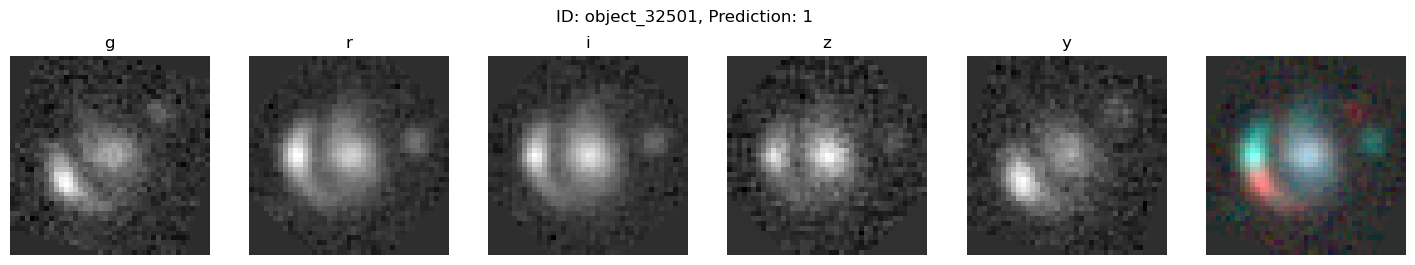

  0%|          | 2/100000 [00:00<9:11:57,  3.02it/s]

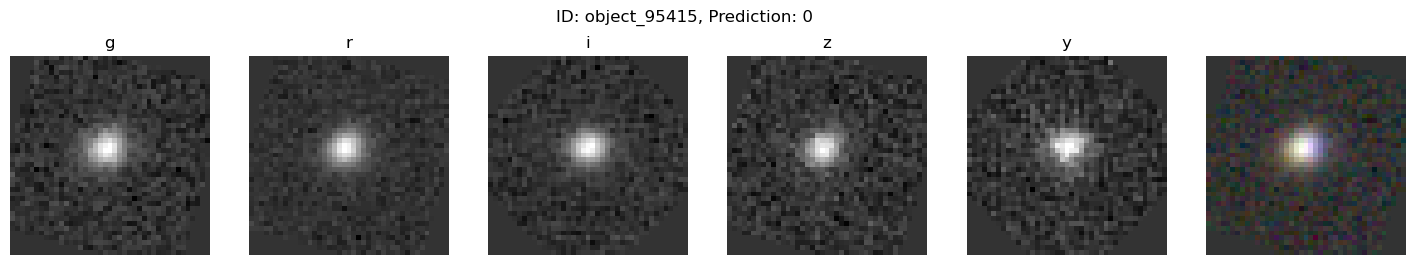

  0%|          | 3/100000 [00:00<9:02:00,  3.07it/s]

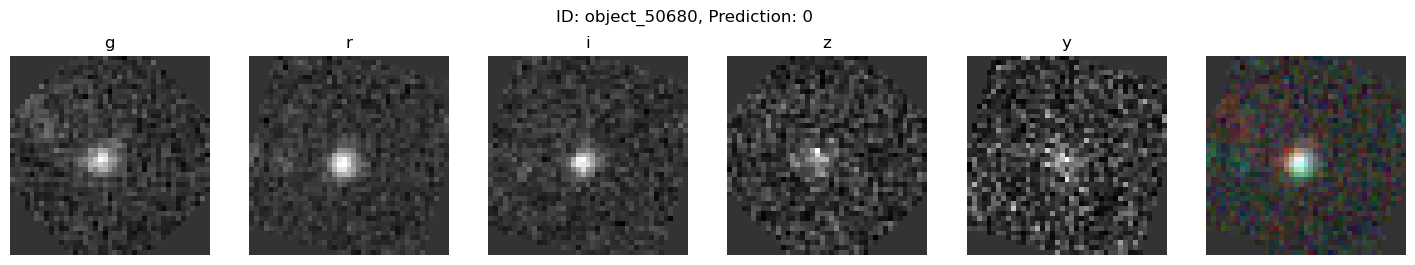

  0%|          | 4/100000 [00:01<11:48:01,  2.35it/s]

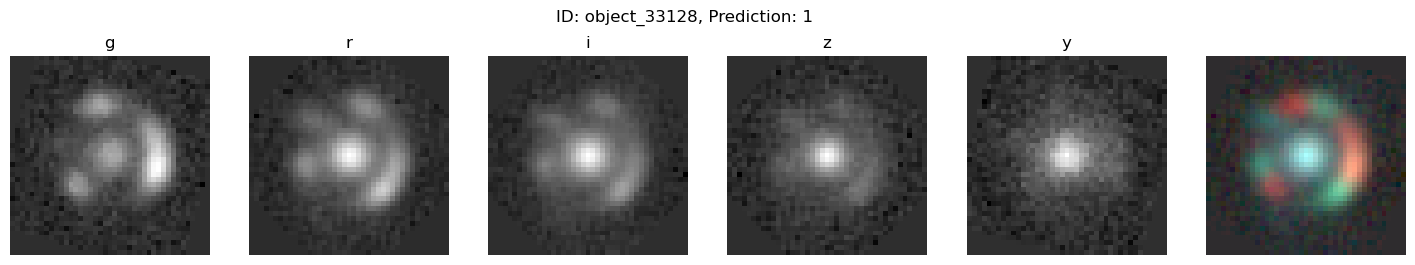

  0%|          | 5/100000 [00:01<10:24:11,  2.67it/s]

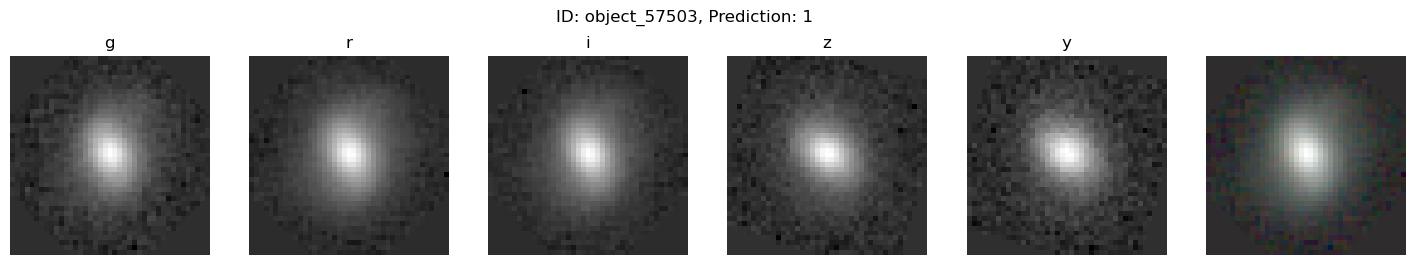

  0%|          | 6/100000 [00:02<9:55:12,  2.80it/s] 

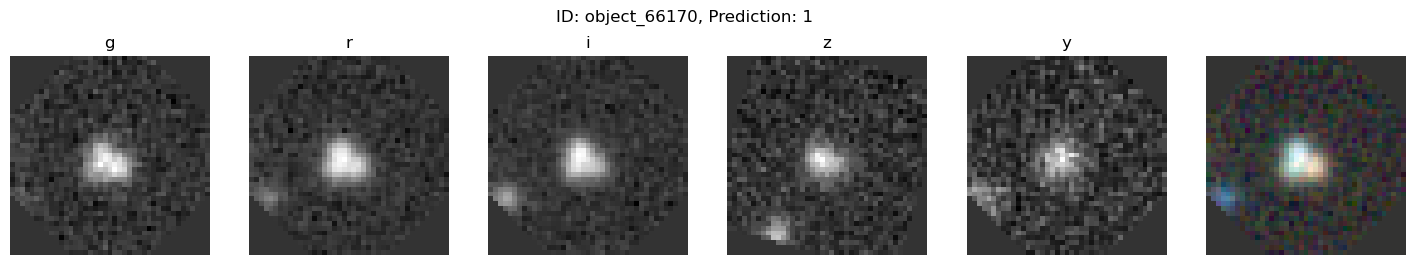

  0%|          | 7/100000 [00:02<9:26:42,  2.94it/s]

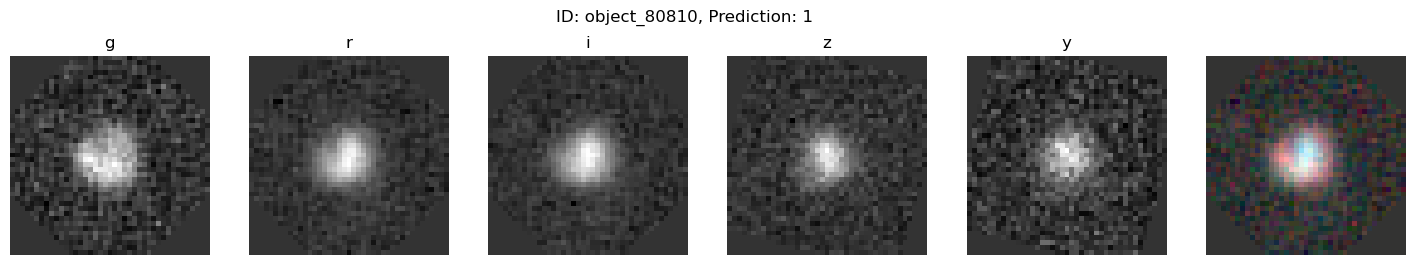

  0%|          | 8/100000 [00:02<9:07:50,  3.04it/s]

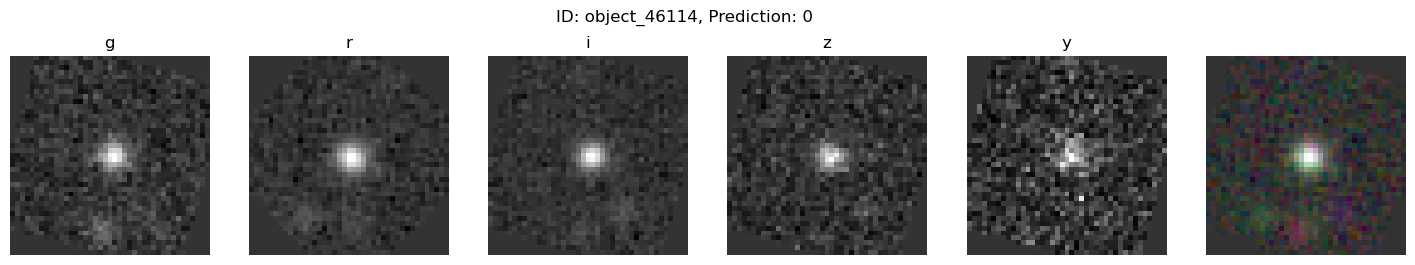

  0%|          | 9/100000 [00:03<9:01:01,  3.08it/s]

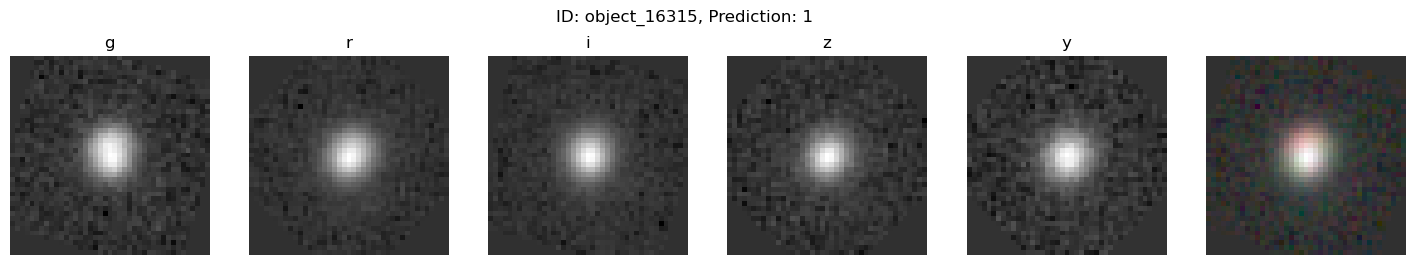

  0%|          | 10/100000 [00:03<8:49:16,  3.15it/s]

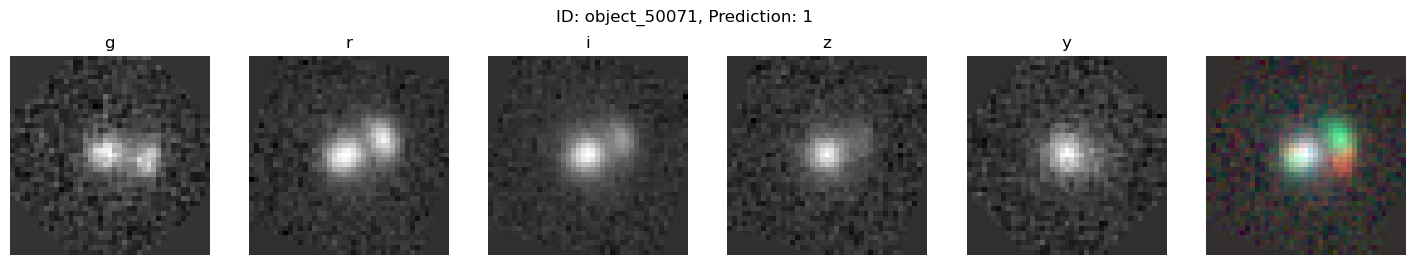

  0%|          | 11/100000 [00:03<8:38:20,  3.21it/s]

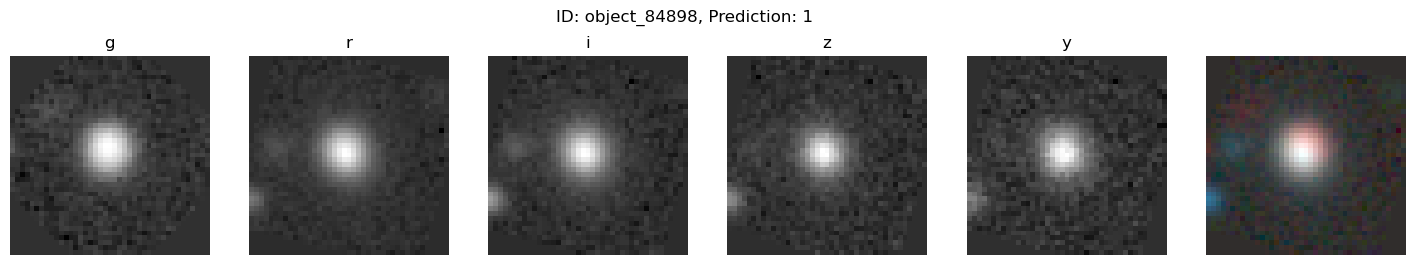

  0%|          | 12/100000 [00:03<8:28:25,  3.28it/s]

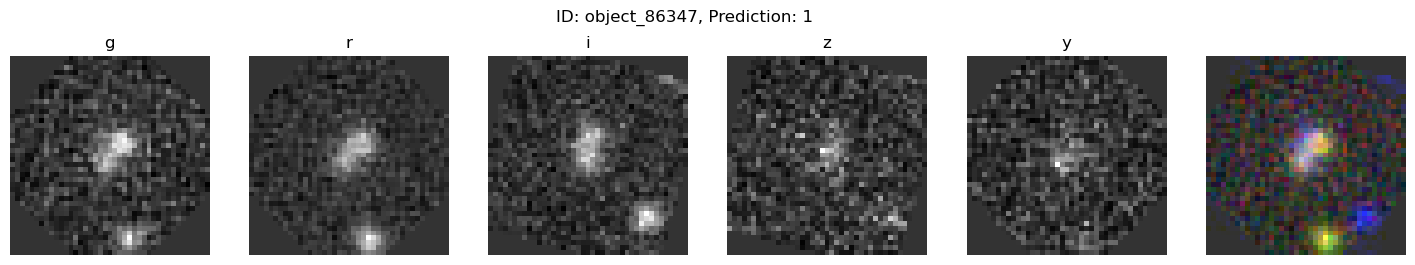

  0%|          | 13/100000 [00:04<8:30:37,  3.26it/s]

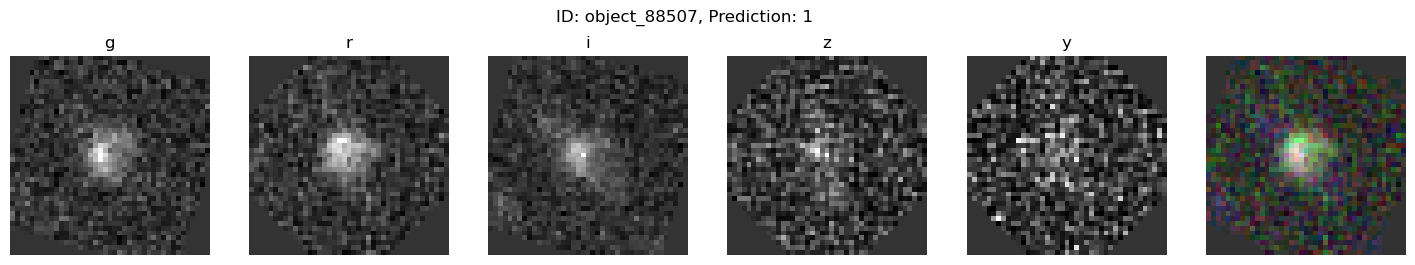

  0%|          | 14/100000 [00:04<8:42:52,  3.19it/s]

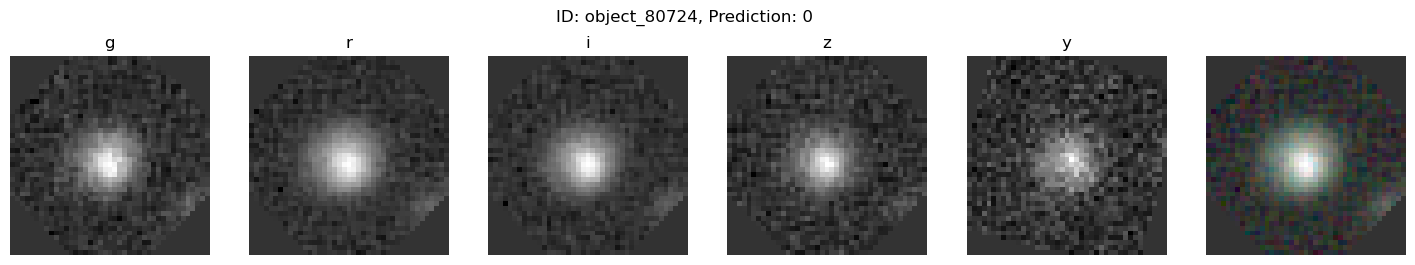

  0%|          | 15/100000 [00:04<8:31:10,  3.26it/s]

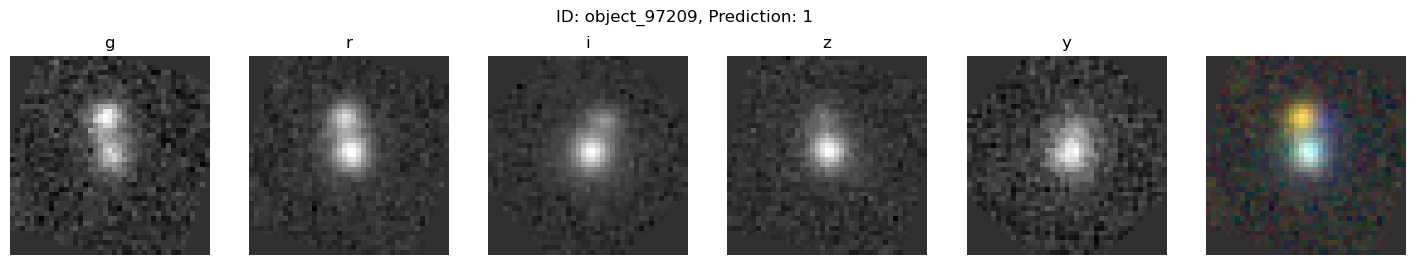

  0%|          | 16/100000 [00:05<8:36:05,  3.23it/s]

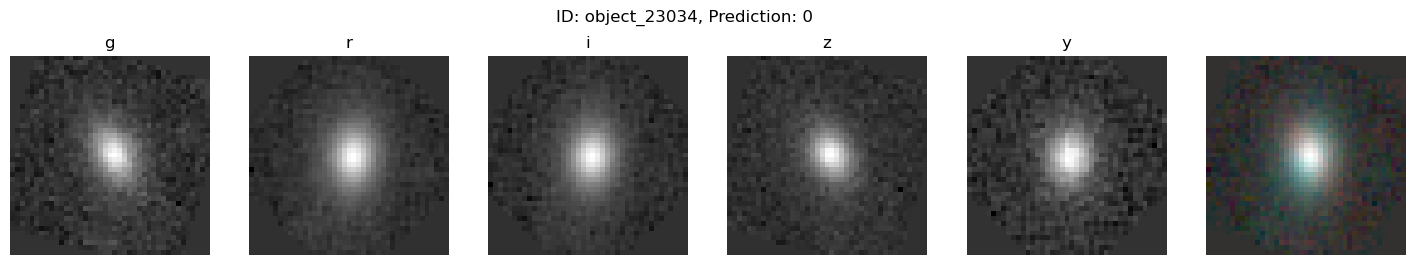

  0%|          | 17/100000 [00:05<8:32:04,  3.25it/s]

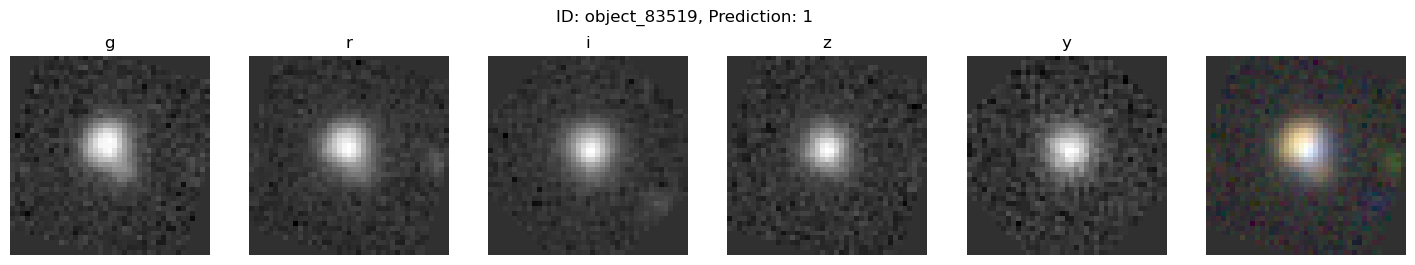

  0%|          | 18/100000 [00:05<8:22:24,  3.32it/s]

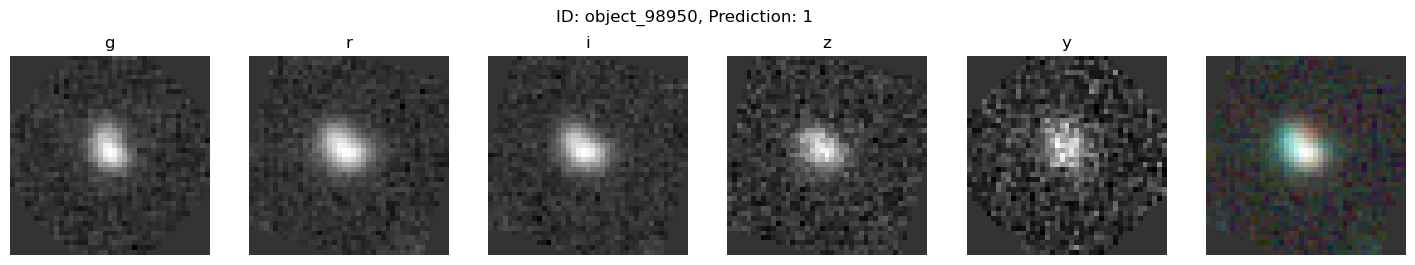

  0%|          | 19/100000 [00:06<8:26:11,  3.29it/s]

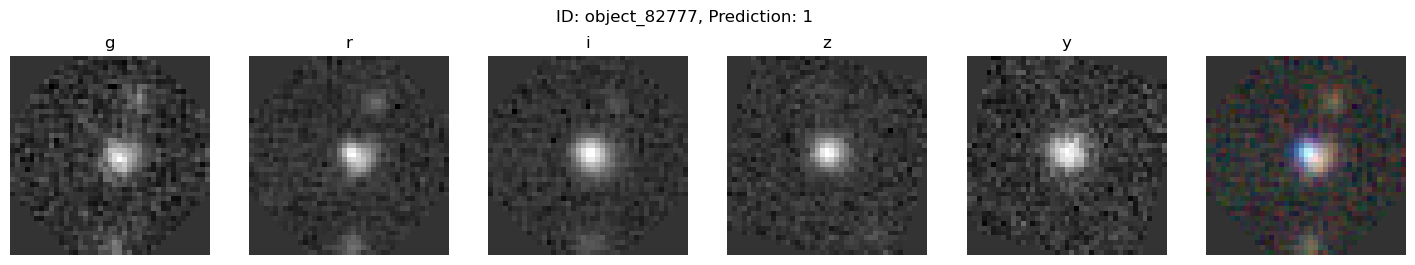

  0%|          | 20/100000 [00:06<11:35:34,  2.40it/s]

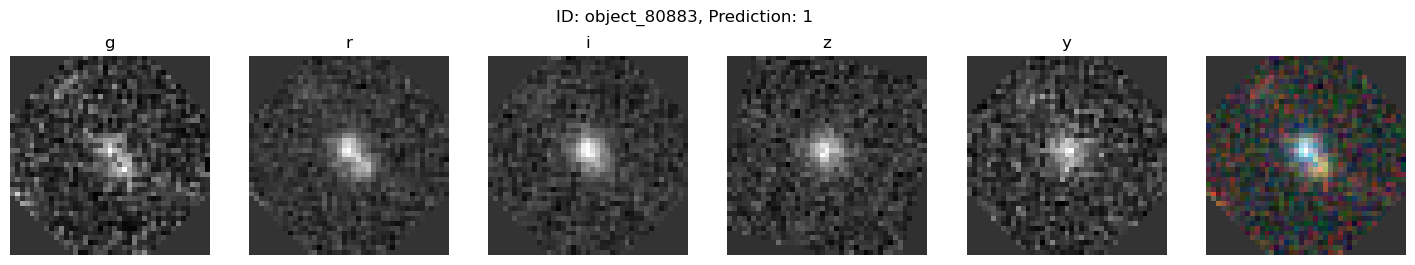

  0%|          | 21/100000 [00:07<11:05:11,  2.51it/s]

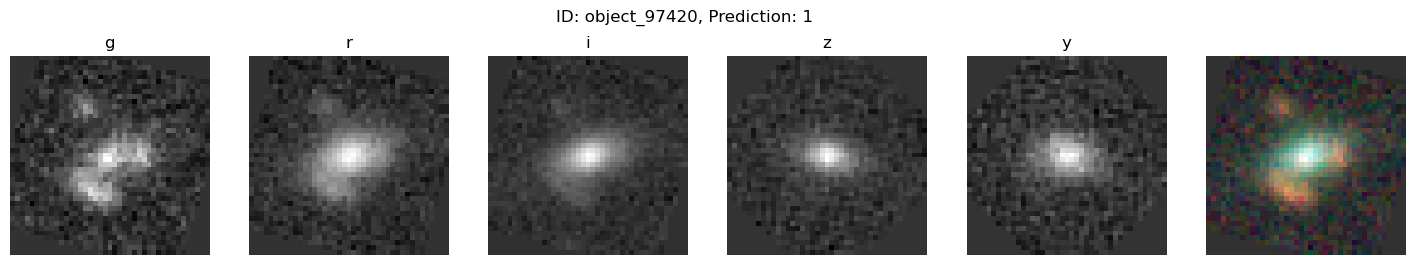

  0%|          | 22/100000 [00:07<10:19:03,  2.69it/s]

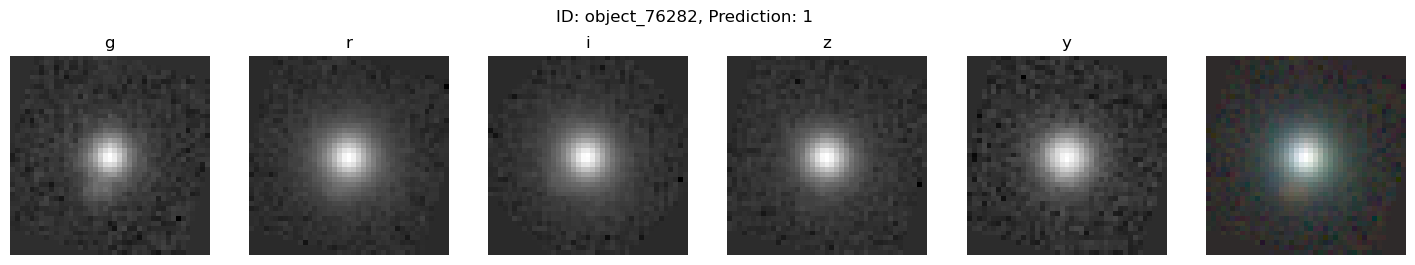

  0%|          | 23/100000 [00:07<9:53:56,  2.81it/s] 

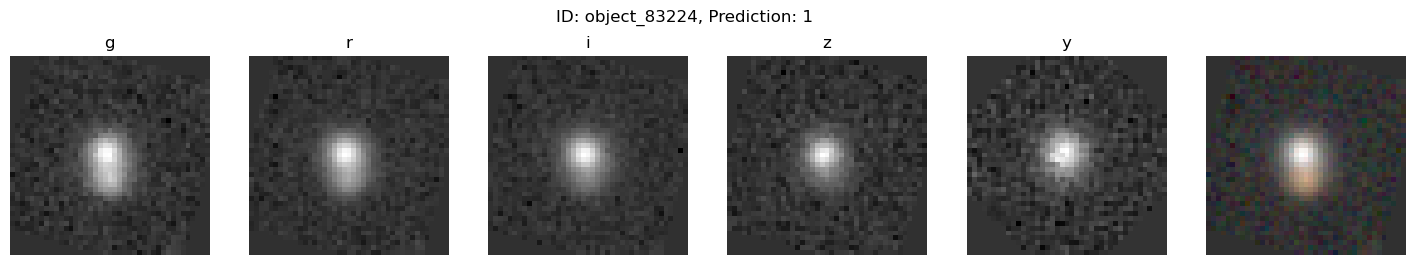

  0%|          | 24/100000 [00:08<10:51:14,  2.56it/s]

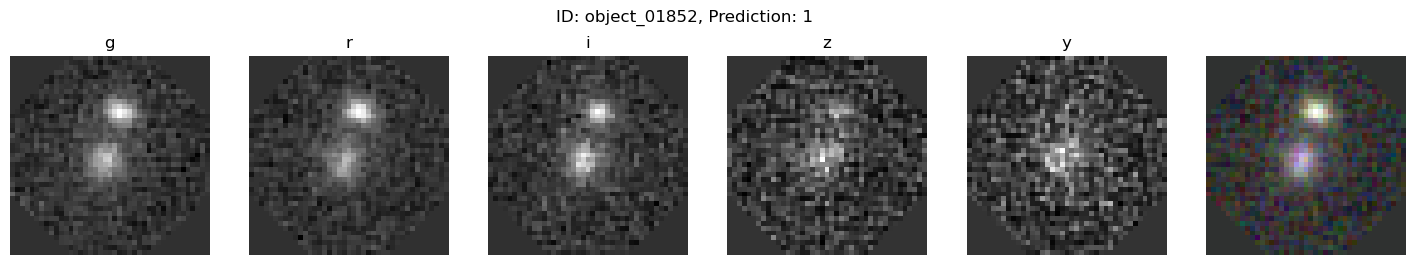

  0%|          | 25/100000 [00:08<10:04:00,  2.76it/s]

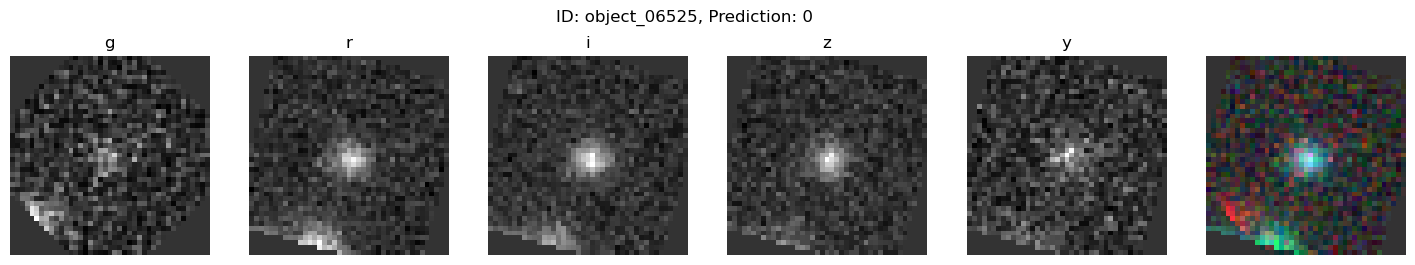

  0%|          | 25/100000 [00:08<9:49:46,  2.83it/s] 


In [33]:
bands = ['g', 'r', 'i', 'z', 'y']

for i, unique_str in tqdm(enumerate(unique_ids), total=len(unique_ids)):
    images = []
    for band in bands:
        file_path = os.path.join(data_dir, f'{unique_str}_{band}.fits')
        id, image = get_image_data(file_path)
        images.append(process_image(image))
    image_stack = np.stack(images, axis=-1)

    # make prediction
    input_stack = np.expand_dims(image_stack, axis=0)  # add batch dimension for prediction
    preds = model.predict(input_stack, verbose=0)
    prediction = int(keras.ops.sigmoid(preds).numpy().flatten()[0] > 0.5)
    # print(f"ID: {id}, Prediction: {prediction}")

    # append to dataframe
    new_row = {'id': id, 'preds': prediction}
    df = pd.concat([df, pd.DataFrame([new_row], columns=df.columns)], ignore_index=True)

    # plot subset as sanity check
    if i % 1 == 0:
        f, ax = plt.subplots(1, 6, figsize=(18, 3))
        for j, band in enumerate(bands):
            ax[j].imshow(image_stack[:, :, j], cmap='gray')
            ax[j].set_title(band)
            ax[j].axis('off')
        ax[5].imshow(image_stack[:, :, :3])
        ax[5].axis('off')
        plt.suptitle(f"ID: {id}, Prediction: {prediction}")
        plt.savefig('figures/' + id + '.png')
        plt.show()

    if i == 25:
        break

In [ ]:
df

,id,preds,ra,dec,zlens,mag_lens_g,mag_lens_r,mag_lens_i,mag_lens_z,mag_lens_y,...,n_l_sers,vel_disp,RA,Dec,mag_object_g,mag_object_r,mag_object_i,mag_object_z,mag_object_y,z_central


In [ ]:
df = df.fillna(-999)
df

,id,preds,ra,dec,zlens,mag_lens_g,mag_lens_r,mag_lens_i,mag_lens_z,mag_lens_y,...,n_l_sers,vel_disp,RA,Dec,mag_object_g,mag_object_r,mag_object_i,mag_object_z,mag_object_y,z_central


In [ ]:
df.to_csv('/data/bwedig/lsst-strong-lens-data-challenge/bryce_submission.csv', index=False)